In [ ]:
!pip install gensim
!pip install transformers
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 19.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import gensim.downloader as api
from gensim.models import KeyedVectors
from transformers import AutoTokenizer, AutoModel
import torch

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
import faiss

In [ ]:
# to check the models
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
model_name = 'glove-wiki-gigaword-100'
word_vectors = api.load(model_name)

print(f"Loaded '{model_name}' with vector size '{word_vectors.vector_size}'")

[==================================================] 100.0% 128.1/128.1MB downloaded
Loaded 'glove-wiki-gigaword-100' with vector size '100'


# Word Analogy **bold text**

In [ ]:
from numpy.linalg import norm

In [ ]:
analogy_vector = word_vectors['king'] - word_vectors['man'] + word_vectors['woman']

### Vctors may be normalised. Normalization is not important in this eg. so we skip **it**

In [ ]:
result = word_vectors.most_similar([analogy_vector], topn=5)

In [ ]:
print(result)

[('king', 0.8551837205886841), ('queen', 0.783441424369812), ('monarch', 0.6933802366256714), ('throne', 0.6833109855651855), ('daughter', 0.6809081435203552)]


In [ ]:
# This is optional

result = [(word, sim) for word, sim in result if word !='king']
print("Result of 'king - man + woman': ")
for word, sim in result[:5]:  # Top 5 excluding "king"
  print(f"  {word}: {sim:.4}")

Result of 'king - man + woman': 
  queen: 0.7834
  monarch: 0.6934
  throne: 0.6833
  daughter: 0.6809


# Transformer based **Embeddings** (Sentence Embedding)

In [ ]:
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
sentences = [
    "This is a sentences about machine learning.",
    "Machine learning is facinating.",
    "I love deep learning!",
    "The cat sat on the mat.",
    "Artificial intelligance is the new electricity."
]

In [ ]:
sentence_embeddings = sentence_model.encode(sentences)

print("Sentence Embeddings Shape:",sentence_embeddings.shape)

Sentence Embeddings Shape: (5, 384)


In [ ]:
sim_matrix = cosine_similarity(sentence_embeddings)

print("Cosine Similarity Matrix:\n", sim_matrix)

Cosine Similarity Matrix:
 [[ 1.0000001   0.5548765   0.32358083 -0.02409415  0.25374708]
 [ 0.5548765   1.          0.4516152  -0.00184712  0.24240729]
 [ 0.32358083  0.4516152   1.0000001  -0.03443442  0.19443256]
 [-0.02409415 -0.00184712 -0.03443442  1.0000001   0.01689226]
 [ 0.25374708  0.24240729  0.19443256  0.01689226  1.0000002 ]]


In [ ]:
# Effenciency

sentence_embeddings_16 = sentence_embeddings.astype(np.float16)
sim_matrix_16 = cosine_similarity(sentence_embeddings_16)
print("Cosine Similarity Matrix (float16):\n", sim_matrix_16)

Cosine Similarity Matrix (float16):
 [[ 1.          0.55488436  0.32358775 -0.02410406  0.25376965]
 [ 0.55488436  1.          0.45163281 -0.00183231  0.24239817]
 [ 0.32358775  0.45163281  1.         -0.03442374  0.19442632]
 [-0.02410406 -0.00183231 -0.03442374  1.          0.01686084]
 [ 0.25376965  0.24239817  0.19442632  0.01686084  1.        ]]


# Vector Stores (**faiss**)

In [ ]:
d = sentence_embeddings.shape[1]
index = faiss.IndexFlatL2(d)

if sentence_embeddings.dtype != np.float32:
  sentence_embeddings_f32 = sentence_embeddings.astype(np.float32)
else:
  sentence_embeddings_f32 = sentence_embeddings

index.add(sentence_embeddings_f32)

query_sentence = "I enjoy studying artificial intelligence."
query_embedding = sentence_model.encode([query_sentence]).astype(np.float32)

k = 3
distances, indices = index.search(query_embedding, k)

print(f"Query sentence: '{query_sentence}' ")
for i, idx in enumerate(indices[0]):
  print(f"Neighbor #{i+1}: {sentences[idx]} (Distance: {distances[0][i]:.4f})")

Query sentence: 'I enjoy studying artificial intelligence.' 
Neighbor #1: I love deep learning! (Distance: 0.9913)
Neighbor #2: Machine learning is facinating. (Distance: 1.2429)
Neighbor #3: Artificial intelligance is the new electricity. (Distance: 1.2556)


# Advanced vector **indexing**

In [ ]:
import faiss
import numpy as np

In [ ]:
print("Simulating a large dataset by replicating embeddings...")
large_embeddings = np.vstack([sentence_embeddings_f32 for _ in range(1000)])
print(f"Simulating dataset size: {large_embeddings.shape[0]} vectors, each of dimension {large_embeddings.shape[1]}")

Simulating a large dataset by replicating embeddings...
Simulating dataset size: 5000 vectors, each of dimension 384


In [ ]:
num_vectors = large_embeddings.shape[0]
d = large_embeddings.shape[1]
nlist = 100

In [ ]:
print("\nStep 1 : Creating the FAISS quantizer...")
quantizer = faiss.IndexFlatL2(d)
print("Quantizer created using L2 distance metric.")


Step 1 : Creating the FAISS quantizer...
Quantizer created using L2 distance metric.


In [ ]:
print("\nStep 2 : Creating the IVF indx...")
index_ivf = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)


Step 2 : Creating the IVF indx...


In [ ]:
print("\nStep 3 : Train the index...")
index_ivf.train(large_embeddings)


Step 3 : Train the index...


In [ ]:
print("\nStep 4 : Adding embeddings...")
index_ivf.add(large_embeddings)


Step 4 : Adding embeddings...


In [ ]:
query_sentence = "Neural networks are powerful."
print("\nQuery Sentence:", query_sentence)

query_embedding = sentence_model.encode([query_sentence]).astype(np.float32)
print("\nQuery Embeddings generated with shape: {query_embedding.shape}")

index_ivf.nprobe = 10
print("\nSearching with nprone:", index_ivf.nprobe)
distances_ivf, indices_ivf = index_ivf.search(query_embedding, k=3)

print("\nResults:")
for i in range(len(indices_ivf[0])):
  print(f"Result {i + 1}:")
  print(f"  Index: {indices_ivf[0][1]}")
  print(f"  Distance: {distances_ivf[0][1]:.4f}")


Query Sentence: Neural networks are powerful.

Query Embeddings generated with shape: {query_embedding.shape}

Searching with nprone: 10

Results:
Result 1:
  Index: 6
  Distance: 0.8410
Result 2:
  Index: 6
  Distance: 0.8410
Result 3:
  Index: 6
  Distance: 0.8410


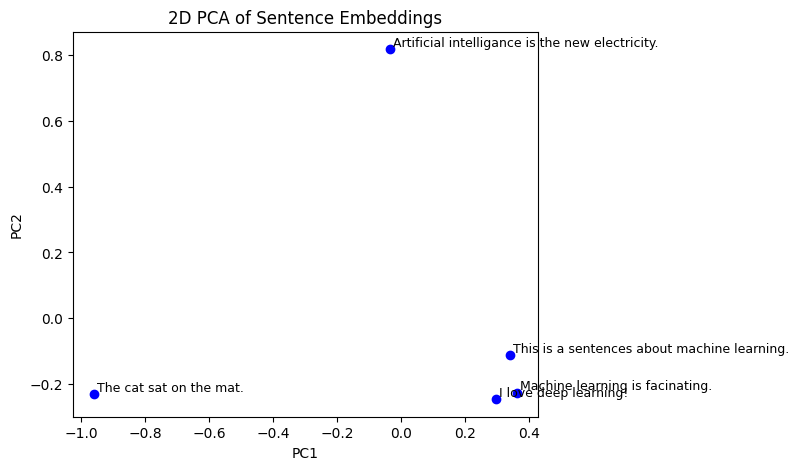

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
import matplotlib.pyplot as plt

X = sentence_embeddings

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(6, 5))
for i, (x, y) in enumerate(X_2d):
    plt.scatter(x, y, color='blue')
    plt.text(x + 0.01, y + 0.01, sentences[i], fontsize=9)

plt.title("2D PCA of Sentence Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
